In [1]:
import xarray as xr
import fsspec
from dask.distributed import Client
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
from vcm.fv3.metadata import gfdl_to_standard, standardize_fv3_diagnostics
from vcm.cubedsphere.regridz import regrid_to_area_weighted_pressure
from vcm.cubedsphere.coarsen import block_upsample_like
from vcm.catalog import catalog
import vcm
import loaders
from loaders.mappers._fine_res_budget import eddy_flux_coarse
import string
xr.set_options(keep_attrs=True)

In [2]:
Client()

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/dashboard/core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==2.2.3.
Continuing without the dashboard.
  warnings.warn(
/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44209 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45415' processes=4 threads=8, memory=29.39 GiB>

In [4]:
url_dycore = 'gs://vcm-ml-raw-flexible-retention/2022-06-27-C3072-snapshot/atmos_15min_ave.zarr'
url_physics = 'gs://vcm-ml-raw-flexible-retention/2022-06-27-C3072-snapshot/gfsphysics_15min.zarr'
url_grid = 'gs://vcm-ml-data/2019-12-12-C3072-model-native-grid-spec.zarr'
url_c3072_sfc = 'gs://vcm-ml-data/2019-12-04-C3072-restart-files-2016-08-16-00/sfc_data.zarr'
land_sea_mask_c48 = catalog['landseamask/c48'].to_dask().load()
grid_c384 = catalog['grid/c384'].to_dask().load()
grid_c48 = catalog['grid/c48'].to_dask().load()
PLOT_TILE = 3
PLOT_TIME = '2016-08-11T00:15:00'
PLOT_KWARGS = dict(x='y', yincrease=False)


In [5]:
def open_zarr(url):
    ds = xr.open_zarr(fsspec.get_mapper(url))
    ds = ds.isel(time=0).drop('time')
    return gfdl_to_standard(ds)

In [7]:
ds_dycore = open_zarr(url_dycore)
ds_physics = open_zarr(url_physics)
grid = open_zarr(url_grid)
lsmsk = gfdl_to_standard(xr.open_zarr(url_c3072_sfc).slmsk.isel(Time=0)).rename(xaxis_1='x', yaxis_1='y')
ds = xr.merge([ds_dycore, ds_physics, lsmsk], compat='override').assign_coords(z=range(79))


<ipython-input-5-20a1c8f81550>:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(fsspec.get_mapper(url))


In [9]:
VARIABLES = ['temp', 'vulcan_omega']

In [10]:
# model-level coarse-grain from C3072 to C48
ds_area_weighted = vcm.cubedsphere.weighted_block_average(
    ds[VARIABLES + ['delp']],
    grid.area,
    8,
    x_dim='x',
    y_dim='y',
)

# regrid from C3072 to C48 pressure levels
regridded, masked_area = regrid_to_area_weighted_pressure(
    ds[VARIABLES],
    ds.delp,
    grid.area,
    8,
    x_dim='x',
    y_dim='y',
    z_dim='z',
)

# pressure-level coarse-grain from C3072 to C48 using masked area
ds_pressure_one_step = vcm.cubedsphere.weighted_block_average(
    regridded,
    masked_area,
    8,
    x_dim='x',
    y_dim='y',
)

# pressure-level coarse-grain from C3072 to C48 using unmasked area
ds_pressure_one_step_unmasked = vcm.cubedsphere.weighted_block_average(
    regridded,
    grid.area,
    8,
    x_dim='x',
    y_dim='y',
)

In [11]:
ds['pressure'] = vcm.pressure_at_midpoint_log(ds.delp, dim='z')
ds_area_weighted['pressure'] = vcm.pressure_at_midpoint_log(ds_area_weighted.delp, dim='z')
ds['surface_pressure'] = vcm.surface_pressure_from_delp(ds.delp).compute()
ds_area_weighted['surface_pressure'] = vcm.surface_pressure_from_delp(ds_area_weighted.delp)

In [12]:
ds['c48_pressure'] = block_upsample_like(ds_area_weighted.pressure, ds.pressure, x_dim='x', y_dim='y')
ds['c48_surface_pressure'] = block_upsample_like(ds_area_weighted.surface_pressure, ds.surface_pressure, x_dim='x', y_dim='y')
ds['c48_land_sea_mask'] = block_upsample_like(land_sea_mask_c48.land_sea_mask, ds.surface_pressure, x_dim='x', y_dim='y')


/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/dataset.py:2145: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


In [16]:
# model-level coarse-grain from C3072 to C48
ds_area_weighted = vcm.cubedsphere.weighted_block_average(
    ds[VARIABLES + ['delp']],
    grid.area,
    64,
    x_dim='x',
    y_dim='y',
)

# regrid from C3072 to C48 pressure levels
regridded, masked_area = regrid_to_area_weighted_pressure(
    ds[VARIABLES],
    ds.delp,
    grid.area,
    64,
    x_dim='x',
    y_dim='y',
    z_dim='z',
)

# pressure-level coarse-grain from C3072 to C48 using masked area
ds_pressure_one_step = vcm.cubedsphere.weighted_block_average(
    regridded,
    masked_area,
    64,
    x_dim='x',
    y_dim='y',
)

# pressure-level coarse-grain from C3072 to C48 using unmasked area
ds_pressure_one_step_unmasked = vcm.cubedsphere.weighted_block_average(
    regridded,
    grid.area,
    64,
    x_dim='x',
    y_dim='y',
)

In [17]:
ds['pressure'] = vcm.pressure_at_midpoint_log(ds.delp, dim='z')
ds_area_weighted['pressure'] = vcm.pressure_at_midpoint_log(ds_area_weighted.delp, dim='z')
ds['surface_pressure'] = vcm.surface_pressure_from_delp(ds.delp).compute()
ds_area_weighted['surface_pressure'] = vcm.surface_pressure_from_delp(ds_area_weighted.delp)


In [18]:
ds['c48_pressure'] = block_upsample_like(ds_area_weighted.pressure, ds.pressure, x_dim='x', y_dim='y')
ds['c48_surface_pressure'] = block_upsample_like(ds_area_weighted.surface_pressure, ds.surface_pressure, x_dim='x', y_dim='y')
ds['c48_land_sea_mask'] = block_upsample_like(land_sea_mask_c48.land_sea_mask, ds.surface_pressure, x_dim='x', y_dim='y')

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/dataset.py:2145: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


In [19]:
# compute coarse-grained temperature and omega at lowest model layer
for variable in ['temp', 'vulcan_omega']:
    print(variable)
    for i, tmp in enumerate([ds_area_weighted, ds_pressure_one_step, ds_pressure_one_step_unmasked]):
        print(i)
        for tile in [3]:
            print(tile)
            tmp[f'{variable}_computed_tile{tile}'] = tmp[variable].isel(z=-1, tile=tile).compute()

temp
0
3
1
3
2
3
vulcan_omega
0
3
1
3
2
3


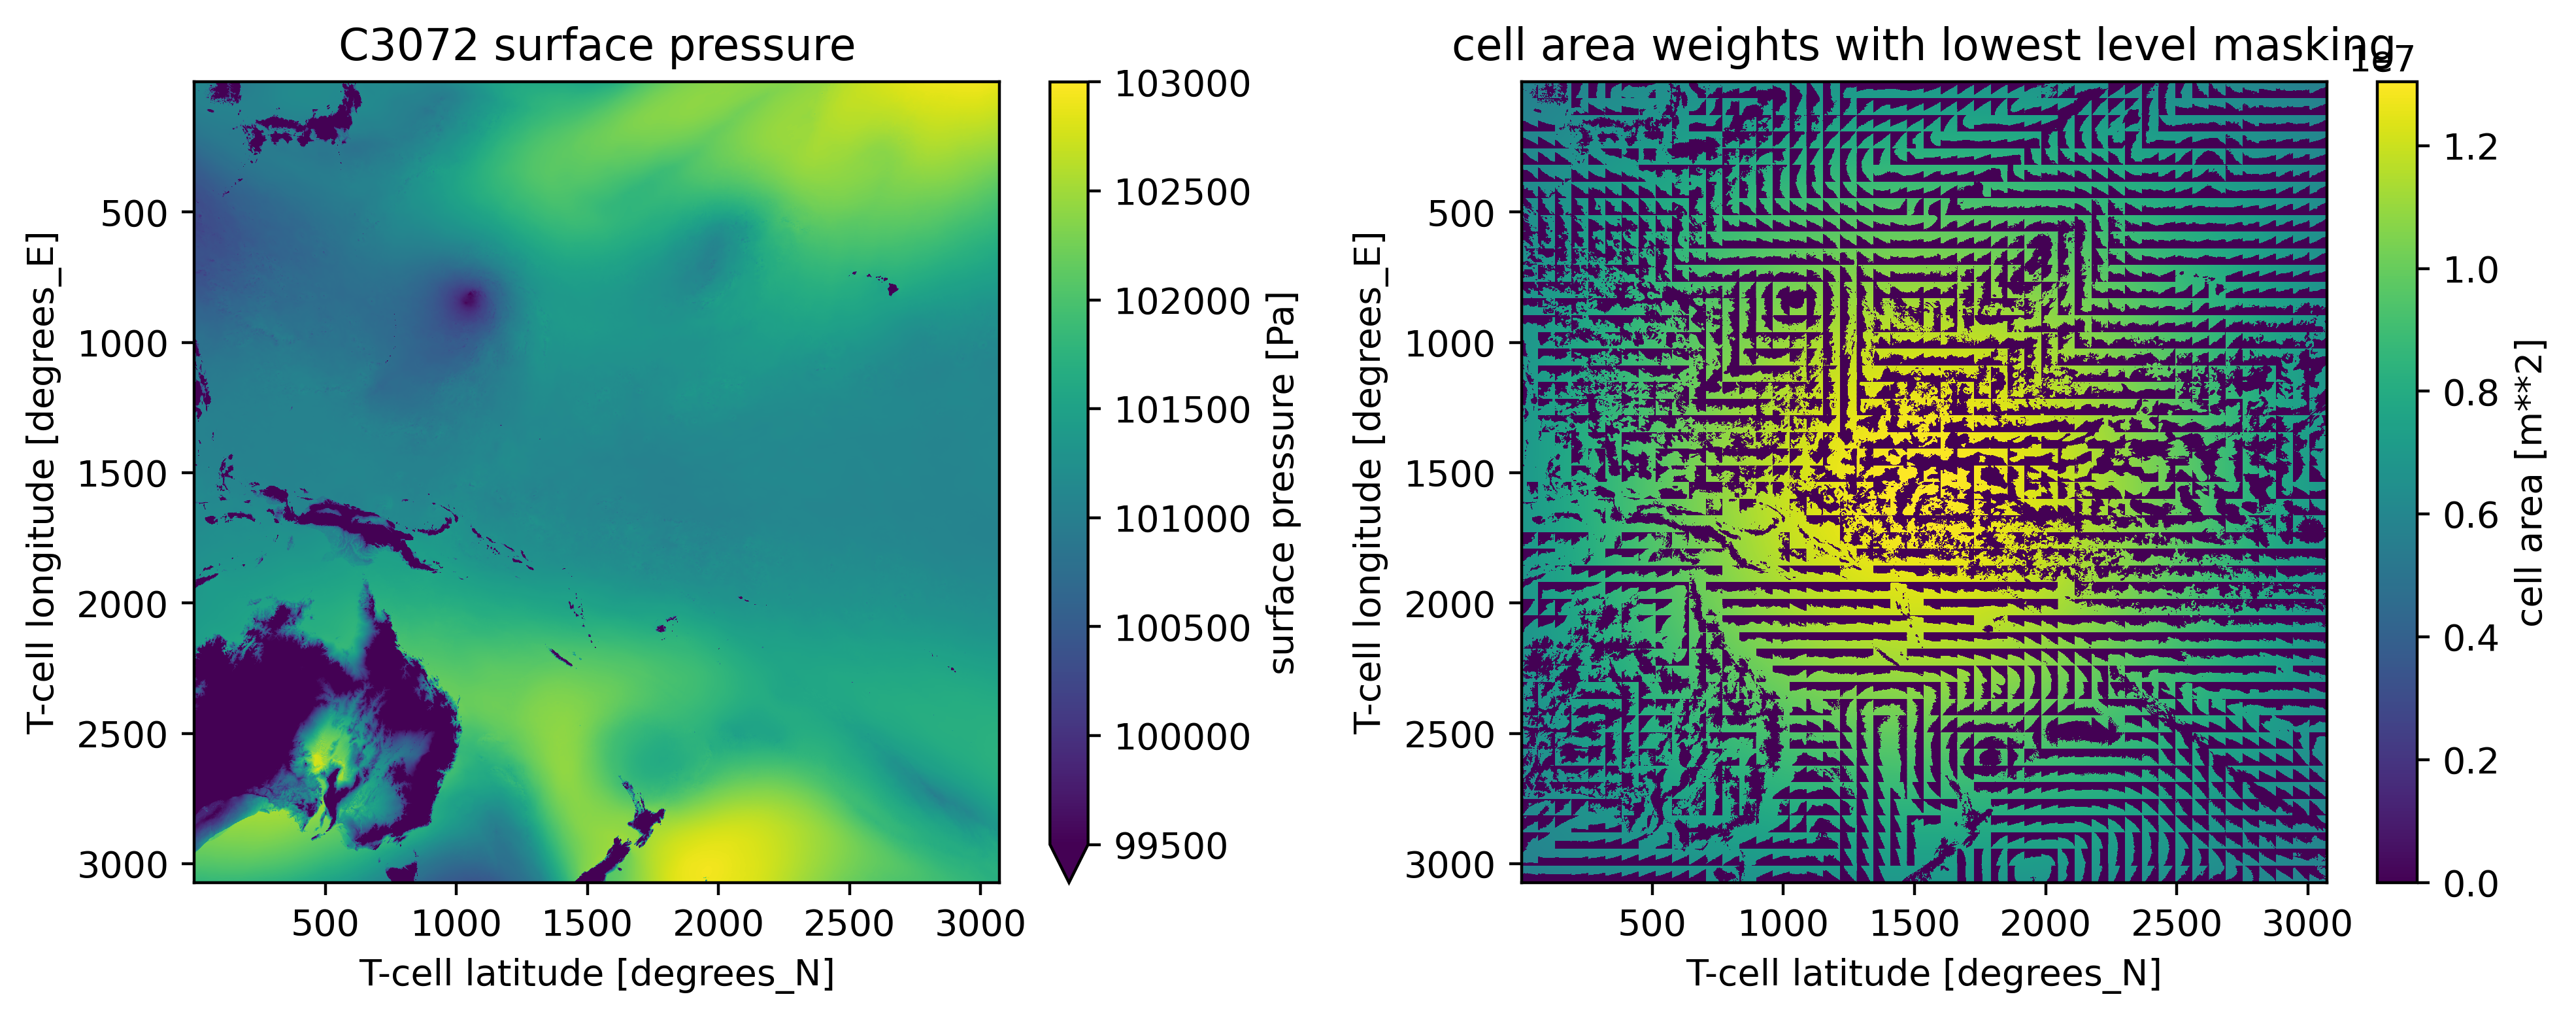

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ds.surface_pressure.isel(tile=PLOT_TILE).plot(ax=axes[0], **PLOT_KWARGS, vmin=99_500, vmax=103_000)
masked_area.isel(z=-1, tile=PLOT_TILE).plot(ax=axes[1], **PLOT_KWARGS)
axes[0].set_title('C3072 surface pressure')
axes[1].set_title('cell area weights with lowest level masking')
fig.tight_layout()

In [26]:
import cartopy.crs as ccrs

In [40]:
axes[0].get_ylim()

(983893.7301168693, 3701294.085148541)

In [44]:
 ds.vulcan_omega.isel(z=-1, **zone).min().compute()

<xarray.DataArray 'vulcan_omega' ()>
array(-5.0998583, dtype=float32)
Coordinates:
    tile     int64 4
    z        int64 78
    Time     float32 1.0
Attributes:
    cell_methods:   time: mean
    long_name:      vulcan_omega
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Pa/s

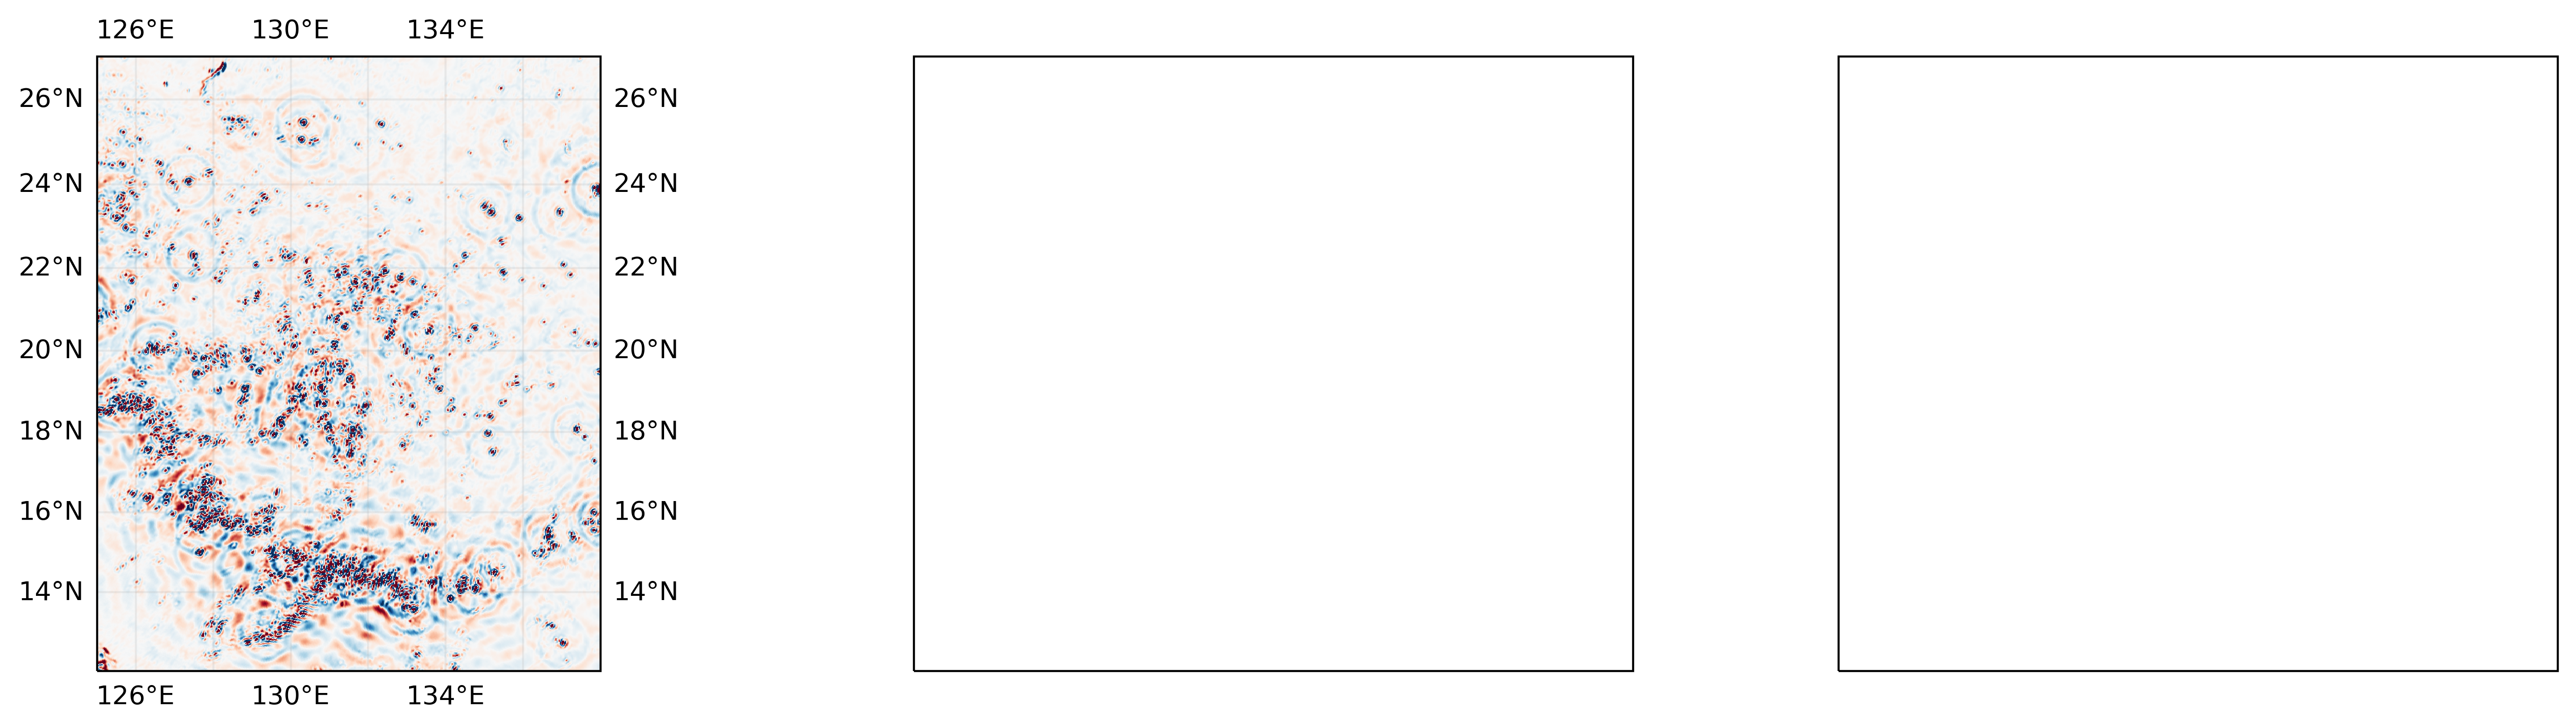

In [45]:
zone = dict(x=slice(350, 1150), y=slice(0, 500), tile=PLOT_TILE)
lat = ds.grid_latt.isel(**zone)
lon = ds.grid_lont.isel(**zone)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Mercator()})
axes[0].pcolormesh(lon, lat, ds.vulcan_omega.isel(z=-1, **zone), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_extent([125, 138, 12, 27], crs=ccrs.PlateCarree())
axes[0].gridlines(draw_labels=True, alpha=0.2)

#ds.vulcan_omega.isel(z=-1, **zone).plot(ax=axes[0], **PLOT_KWARGS, robust=True)
#masked_area.isel(z=-1, **zone).plot(ax=axes[1], **PLOT_KWARGS)
#(ds.vulcan_omega.where(masked_area>0)).isel(z=-1, **zone).plot(ax=axes[2], **PLOT_KWARGS, robust=True)
#axes[0].set_title('C3072 lowest level omega')
#axes[1].set_title('cell area weights with lowest level masking')
#axes[2].set_title('omega weighted by masked area')
fig.tight_layout()

In [38]:
axes[0].set_ylim

Object `set_ylim` not found.


In [ ]:
axes[0].set_ylim

In [24]:
ds

<xarray.Dataset>
Dimensions:               (tile: 6, y: 3072, x: 3072, z: 79, x_interface: 3073, y_interface: 3073, nv: 2)
Coordinates:
  * tile                  (tile) int64 1 2 3 4 5 6
  * x_interface           (x_interface) float32 1.0 2.0 ... 3.072e+03 3.073e+03
  * x                     (x) float32 1.0 2.0 3.0 ... 3.071e+03 3.072e+03
  * y_interface           (y_interface) float32 1.0 2.0 ... 3.072e+03 3.073e+03
  * y                     (y) float32 1.0 2.0 3.0 ... 3.071e+03 3.072e+03
  * nv                    (nv) float32 1.0 2.0
  * z                     (z) int64 0 1 2 3 4 5 6 7 ... 71 72 73 74 75 76 77 78
    Time                  float32 1.0
Data variables: (12/54)
    area                  (tile, y, x) float32 dask.array<chunksize=(1, 384, 384), meta=np.ndarray>
    average_DT            timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
    average_T1            datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    average_T2            datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    delp                  (tile, z, y, x) float32 dask.array<chunksize=(1, 79, 384, 384), meta=np.ndarray>
    delz                  (tile, z, y, x) float32 dask.array<chunksize=(1, 79, 384, 384), meta=np.ndarray>
    ...                    ...
    slmsk                 (tile, y, x) float64 dask.array<chunksize=(1, 384, 384), meta=np.ndarray>
    pressure              (tile, z, y, x) float32 dask.array<chunksize=(1, 79, 384, 384), meta=np.ndarray>
    surface_pressure      (tile, y, x) float32 1.027e+05 1.027e+05 ... 1.027e+05
    c48_pressure          (tile, z, x, y) float32 dask.array<chunksize=(1, 79, 384, 384), meta=np.ndarray>
    c48_surface_pressure  (tile, x, y) float32 dask.array<chunksize=(1, 64, 64), meta=np.ndarray>
    c48_land_sea_mask     (tile, x, y) float64 0.0 0.0 0.0 0.0 ... nan nan nan